In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import plotly.graph_objects as go
import plotly.express as px

import ipywidgets as widgets
from IPython.display import display, clear_output

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
network = ''
networks_names = ['', 'PokerStars', 'GGNetwork', 'Winamax.fr', 'PokerStars(FR-ES-PT)']

def change_data(change):
    global network
    network = dropdown_network.value


dropdown_network = widgets.Dropdown(options = networks_names)
dropdown_network.observe(change_data, names='value')


display(dropdown_network)

Dropdown(options=('', 'PokerStars', 'GGNetwork', 'Winamax.fr', 'PokerStars(FR-ES-PT)'), value='')

In [ ]:
data = pd.read_csv(f'/content/drive/MyDrive/poker_data/{network}.csv')

In [ ]:

data

,@duration,@date,@prizePool,@reEntries,@tickets,@currency,@filterString,@flags,@game,@gameClass,...,TypeCombinedAvROI,TypeAvAbility,TypeAvDuration,TypeAvEntrants,TypeAvITM,@dealMade,timestamp,weekDay,@totalRebuys,@rebuyStake
0,4748,2023-05-05 17:54:08,4000.00,11.0,0,USD,"Class:SCHEDULED;Type:H,NL,ST,6MX;Type!:R;Stake...","ST,6MX,ME",H,scheduled,...,5.9,73.5,5854.0,104.0,18.6,NaN,1683309248,Friday,NaN,NaN
1,13696,2023-05-05 17:48:16,4000.00,11.0,0,USD,"Class:SCHEDULED;Type:H,NL,N;Type!:R;StakePlusR...",ME,H,scheduled,...,4.8,73.3,19747.0,86.0,18.4,3.0,1683308896,Friday,NaN,NaN
2,7254,2023-05-05 17:30:54,5799.99,6.0,0,USD,"Class:SCHEDULED;Type:H,NL,T,B;Type!:R;StakePlu...","B,T,ME",H,scheduled,...,7.6,77.6,7689.0,52.0,44.4,NaN,1683307854,Friday,NaN,NaN
3,4172,2023-05-05 15:54:32,3114.30,6.0,0,USD,"Class:SCHEDULED;Type:H,NL,ST,B;Type!:R;StakePl...","ST,B,ME",H,scheduled,...,3.2,73.8,4313.0,25.0,41.2,NaN,1683302072,Friday,NaN,NaN
4,16441,2023-05-05 15:39:01,3600.00,13.0,0,USD,"Class:SCHEDULED;Type:H,NL,N;Type!:R;StakePlusR...",ME,H,scheduled,...,8.0,74.2,17624.0,54.0,19.8,NaN,1683301141,Friday,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6169,4557,2023-05-25 14:50:57,5388.79,8.0,0,USD,"Class:SCHEDULED;Type:H,NL,ST,B,6MX;Type!:R;Sta...","ST,6MX,B,ME",H,scheduled,...,6.5,74.0,4733.0,58.0,41.5,NaN,1685026257,Thursday,NaN,NaN
6170,11930,2023-05-25 14:48:50,6899.99,5.0,0,USD,"Class:SCHEDULED;Type:H,NL,N,B;Type!:R;StakePlu...","B,ME",H,scheduled,...,8.5,79.2,13008.0,14.0,42.0,NaN,1685026130,Thursday,NaN,NaN
6171,19078,2023-05-25 14:47:58,10000.00,34.0,0,USD,"Class:SCHEDULED;Type:H,NL,N,B;Type!:R;StakePlu...","B,ME",H,scheduled,...,9.4,70.8,19891.0,218.0,43.5,NaN,1685026078,Thursday,NaN,NaN
6172,12195,2023-05-25 14:38:15,5026.57,39.0,0,USD,"Class:SCHEDULED;Type:H,NL,T,B;Type!:R;StakePlu...","B,T,ME",H,scheduled,...,4.5,65.7,12387.0,333.0,42.5,NaN,1685025495,Thursday,NaN,NaN


In [ ]:
data['start_time'] = pd.to_datetime(data['timestamp'] - data['@duration'], unit='s')
data['weekDay'] = data['start_time'].dt.day_name()
data['day_time'] = data['start_time'].dt.strftime('%H:%M')

def rm_ps_es_gtd(tournament_name):
    if tournament_name.endswith('Gtd') or tournament_name.endswith('guaranteed') or tournament_name.endswith('Guaranteed'):
        return ','.join(tournament_name.split(',')[:-2]).strip()
    else:
      return tournament_name

if network == 'PokerStars':
    data['name'] = data['@name'].apply(lambda x: ','.join(x.split(',')[:-1]).strip() if isinstance(x, str) else '')
elif network == 'PokerStars(FR-ES-PT)':
    data['name'] = data['@name'].apply(rm_ps_es_gtd)
else:
    data['name'] = data['@name']

data['name+time'] = data['name'] + " at "+ data['day_time']

In [ ]:
tournaments = data['name+time'].unique()
tournaments_names = sorted([str(t) for t in tournaments])
dropdown = widgets.Dropdown(options = tournaments_names)

# Функция обновления графика при выборе опции в выпадающем списке

def update_plot(change):
    mask = data['name+time'] == dropdown.value
    clear_output()
    display(dropdown)
    plt.clf()
    fig, ax = plt.subplots(2, 1, figsize=(10, 8))

    filtered_df = data[mask].sort_values('start_time')
    print(filtered_df['AvAbility'].min())

    # Trend plot
    ax[0].plot(filtered_df['start_time'], filtered_df['AvAbility'], color='green', linewidth=2)
    ax[0].axhline(filtered_df['AvAbility'].mean(), color='red', linestyle='--')
    ax[0].set_title('Trend for  ' + dropdown.value)
    ax[0].set_xlabel('start_time')
    ax[0].set_ylabel('AvAbility')

    # Weekday plot
    dd = filtered_df[['weekDay', 'AvAbility']].groupby('weekDay').mean()
    dd['weekDay'] = dd.index.astype(str)
    ax[1].bar(dd['weekDay'], dd['AvAbility'])
    ax[1].set_title('Weekday histogram for  ' + dropdown.value)
    ax[1].set_xlabel('weekDay')
    ax[1].set_ylabel('AvAbility')
    plt.ylim(dd['AvAbility'].min() - 3, dd['AvAbility'].max() + 3)
    plt.tight_layout()
    plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
    plt.show()


dropdown.observe(update_plot, names='value')


display(dropdown)

Dropdown(options=(' at 15:45', ' at 19:05', ' at 22:00', ' at 22:05', ' at 22:15', ' at 23:00', '$1,050 Battle…

In [ ]:
data['buy-in'] = data['@stake'] + data['@rake']
data['buy-in']

0        44.0
1        44.0
2       109.0
3       109.0
4        55.0
        ...  
6169     82.0
6170    320.0
6171     44.0
6172     16.5
6173     11.0
Name: buy-in, Length: 6174, dtype: float64

**Анализ турниров с одинаковым buy-in**

Dropdown(index=12, options=('1050 $', '109 $', '11 $', '16 $', '162 $', '215 $', '22 $', '27 $', '3 $', '320 $…

<Figure size 640x480 with 0 Axes>

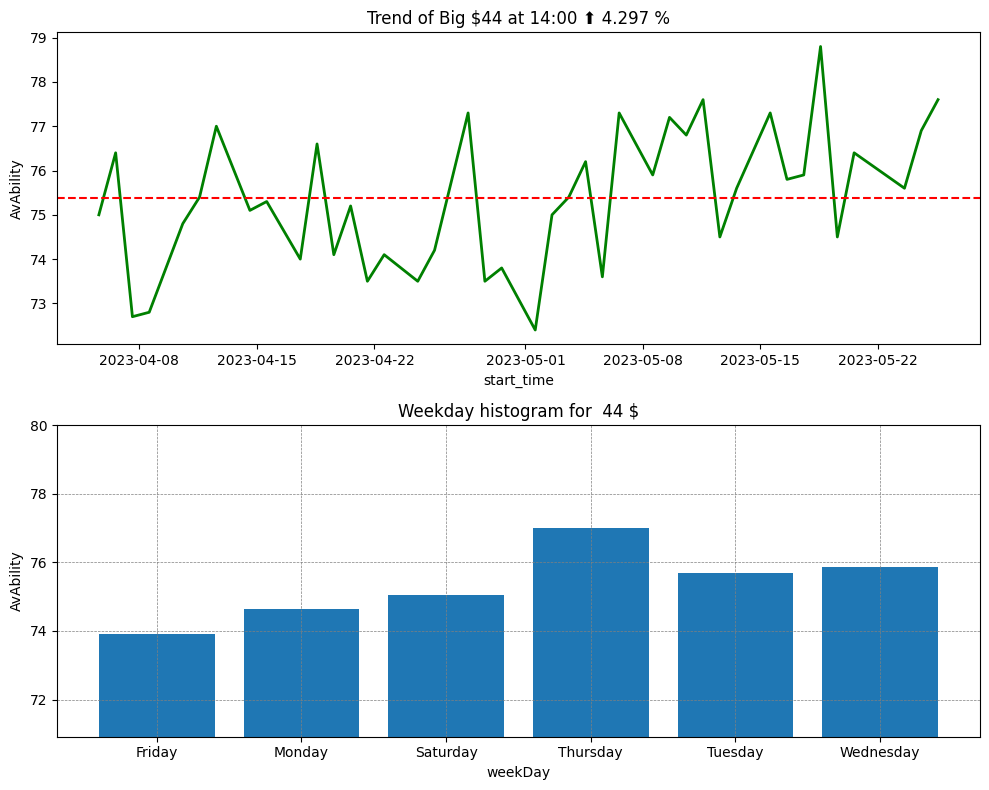

<Figure size 640x480 with 0 Axes>

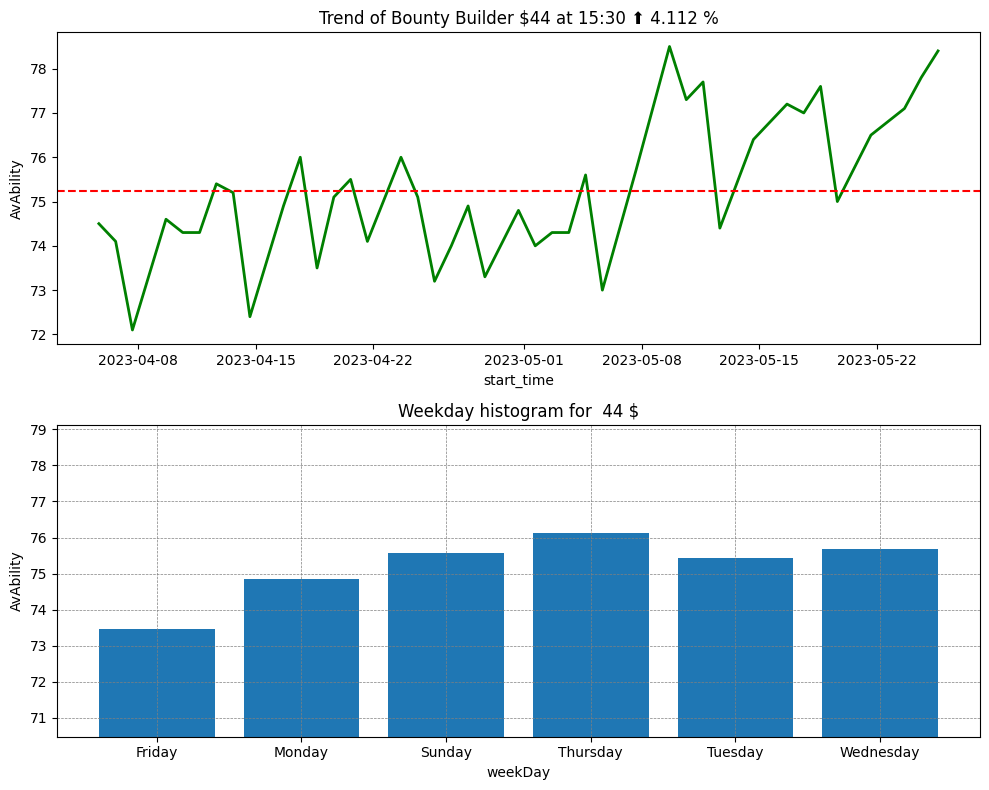

<Figure size 640x480 with 0 Axes>

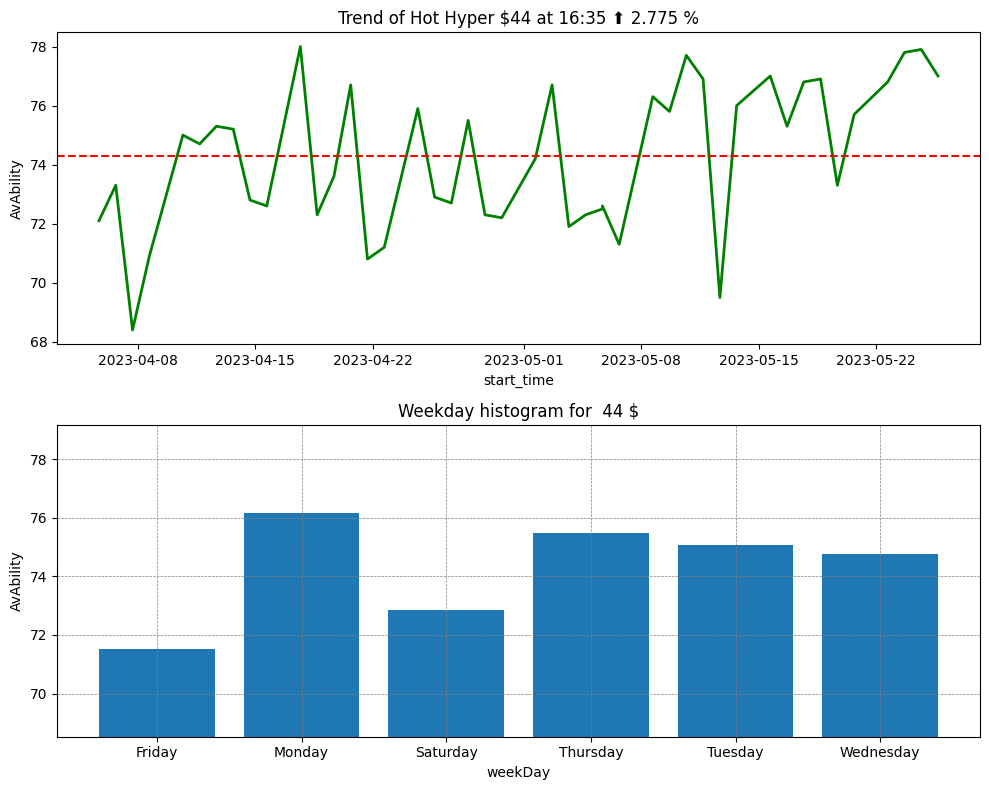

<Figure size 640x480 with 0 Axes>

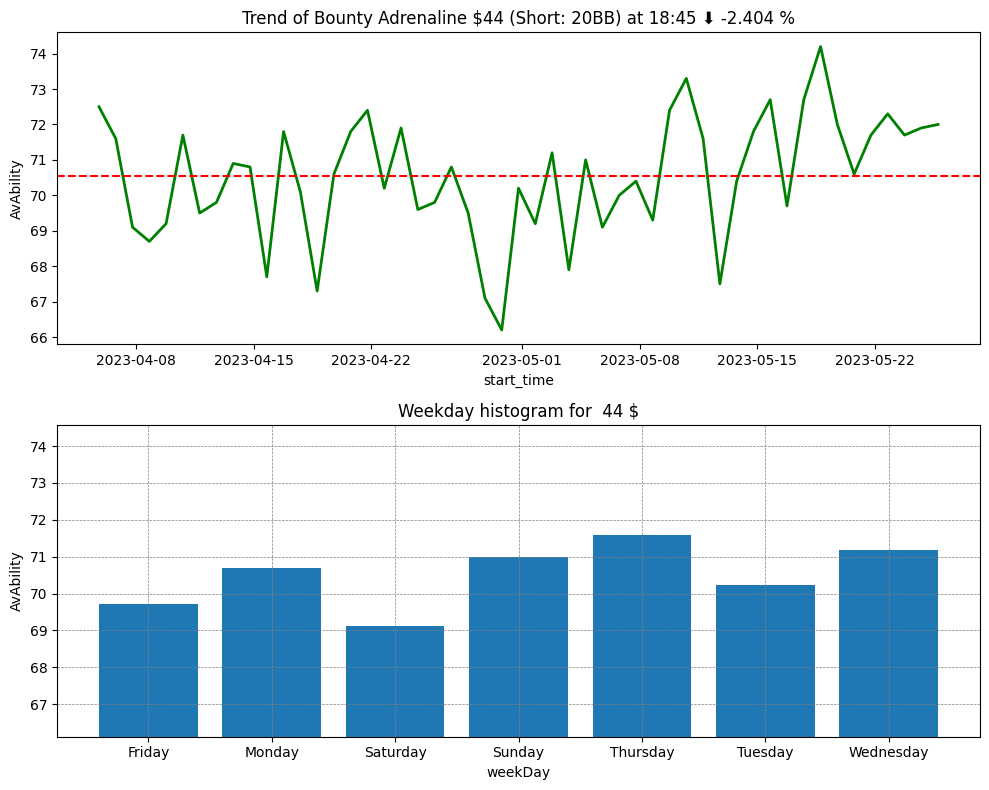

<Figure size 640x480 with 0 Axes>

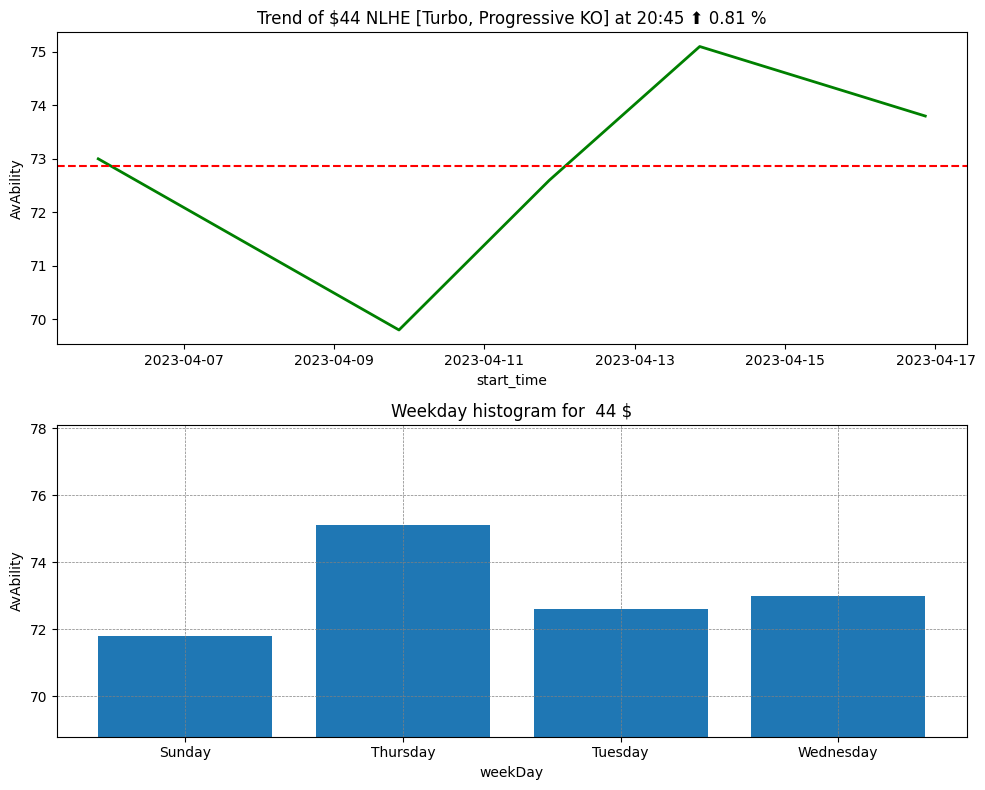

<Figure size 640x480 with 0 Axes>

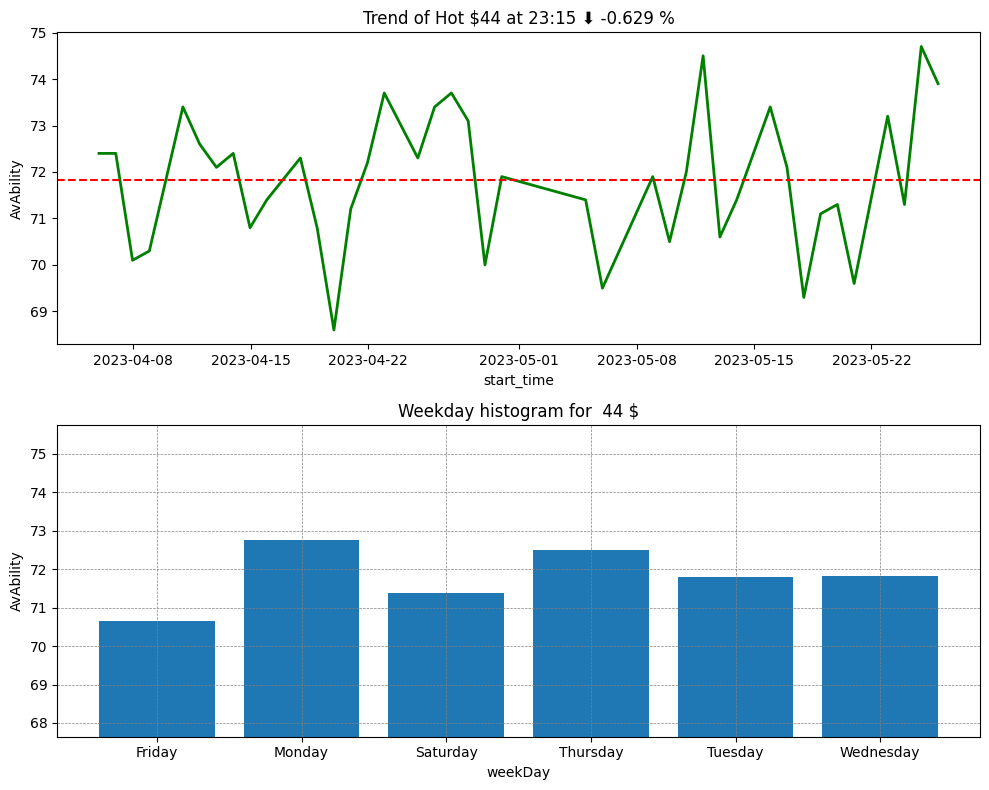

<Figure size 640x480 with 0 Axes>

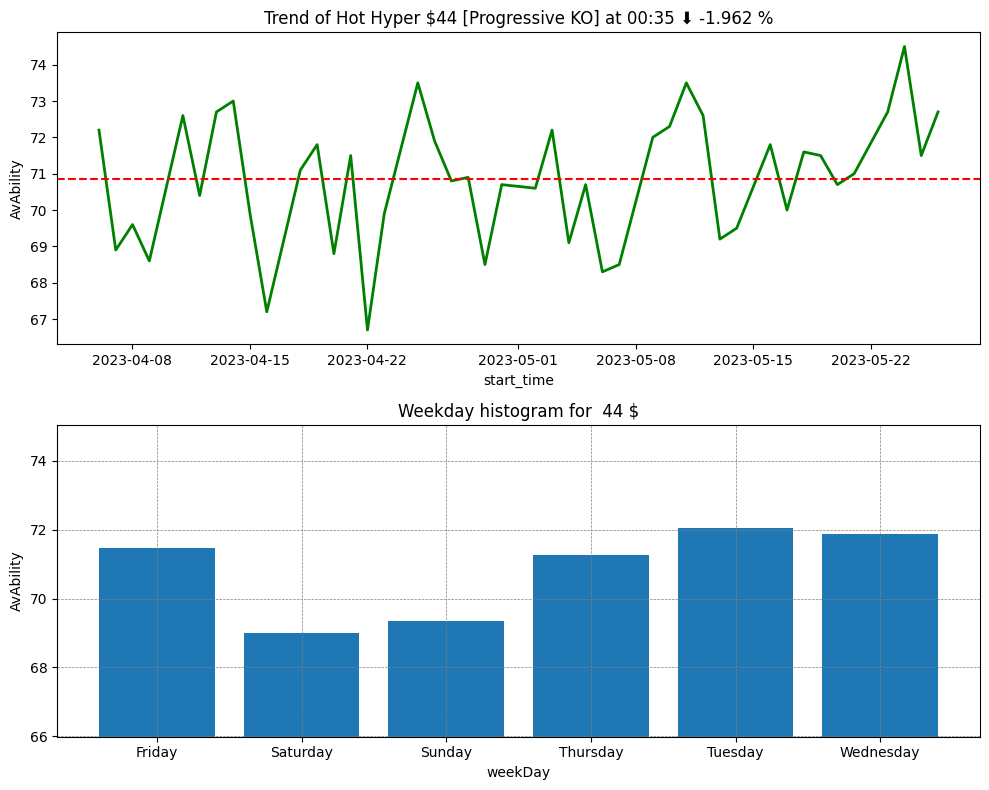

<Figure size 640x480 with 0 Axes>

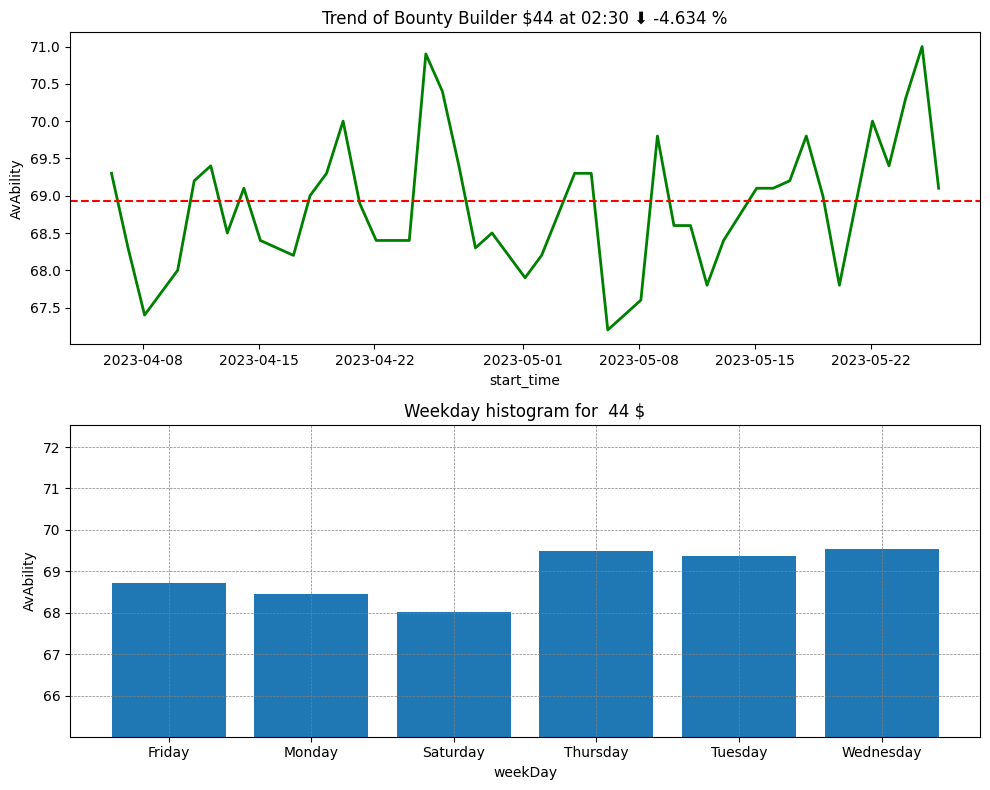

<Figure size 640x480 with 0 Axes>

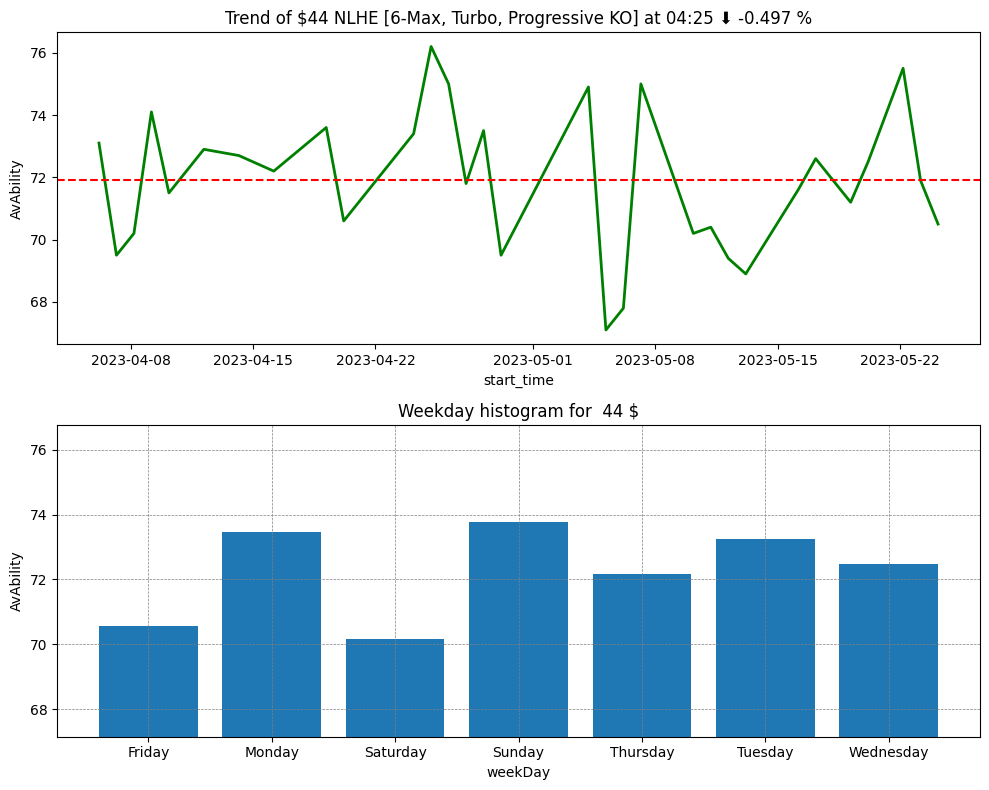

<Figure size 640x480 with 0 Axes>

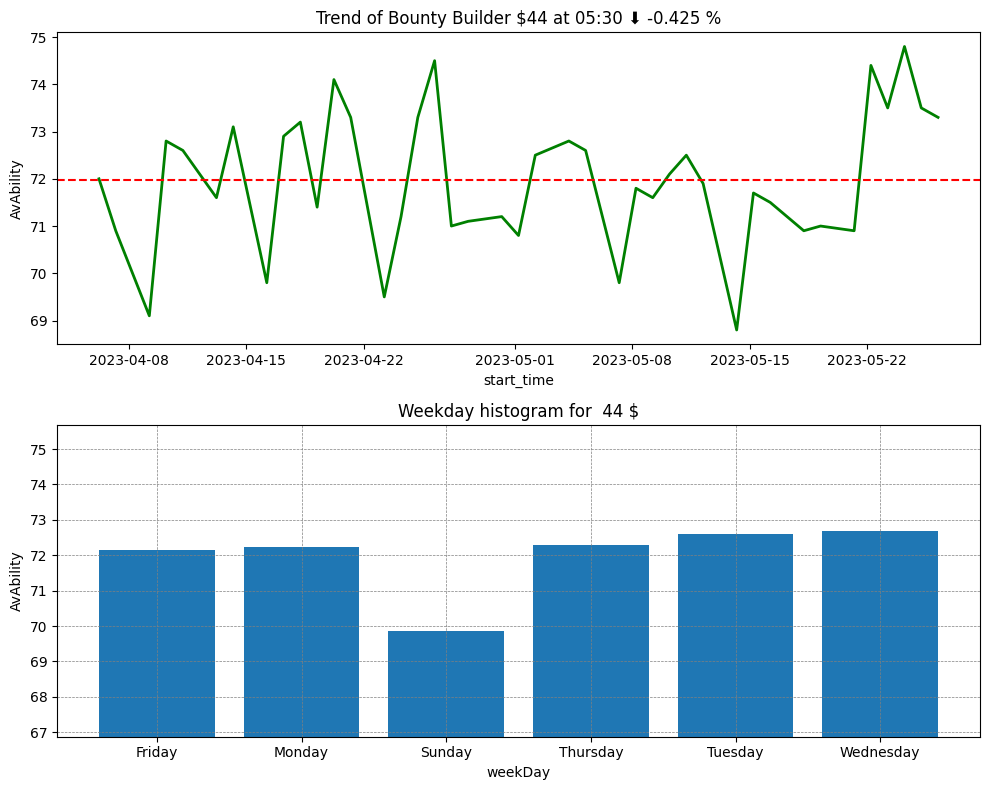

<Figure size 640x480 with 0 Axes>

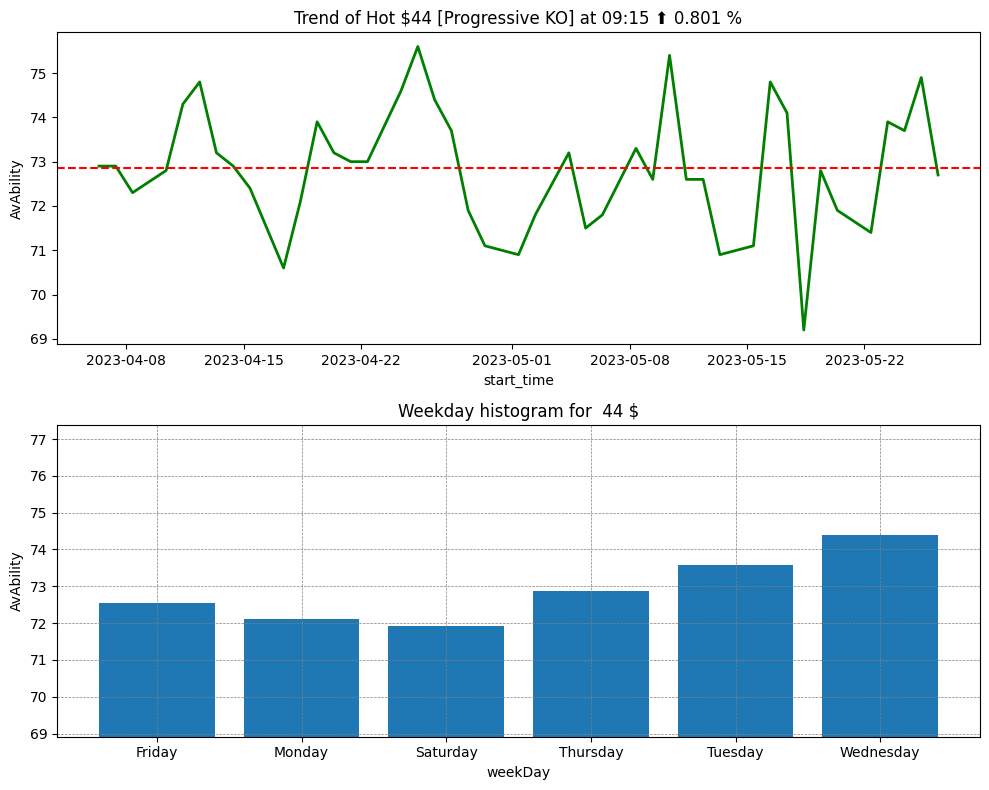

<Figure size 640x480 with 0 Axes>

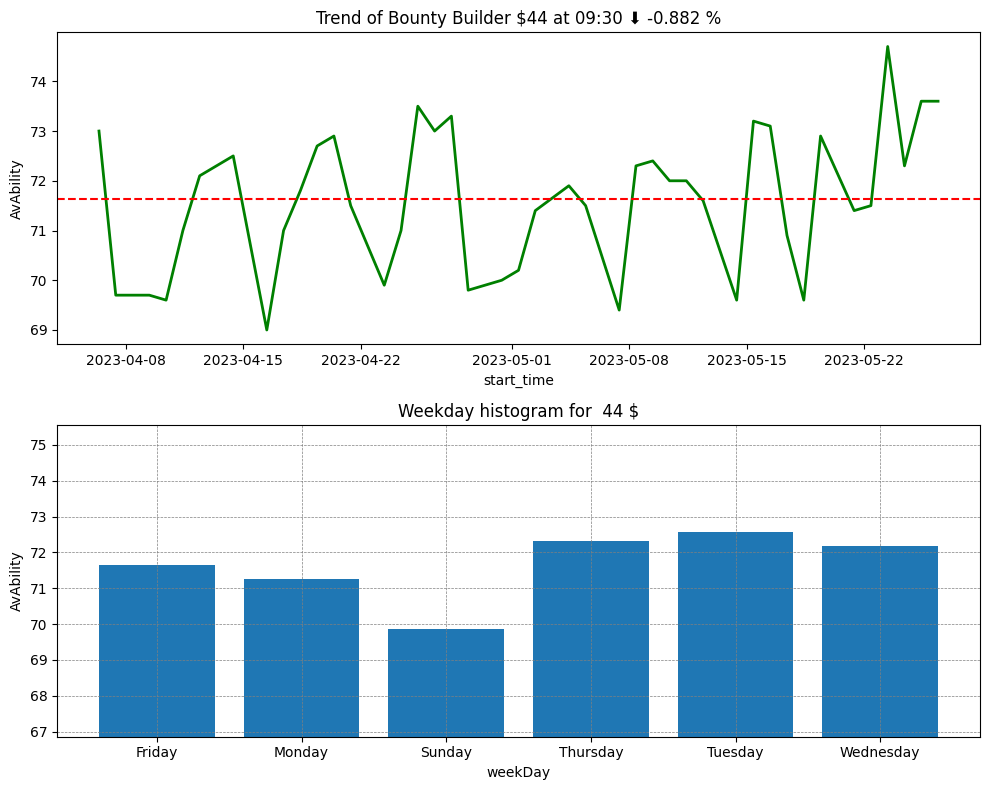

<Figure size 640x480 with 0 Axes>

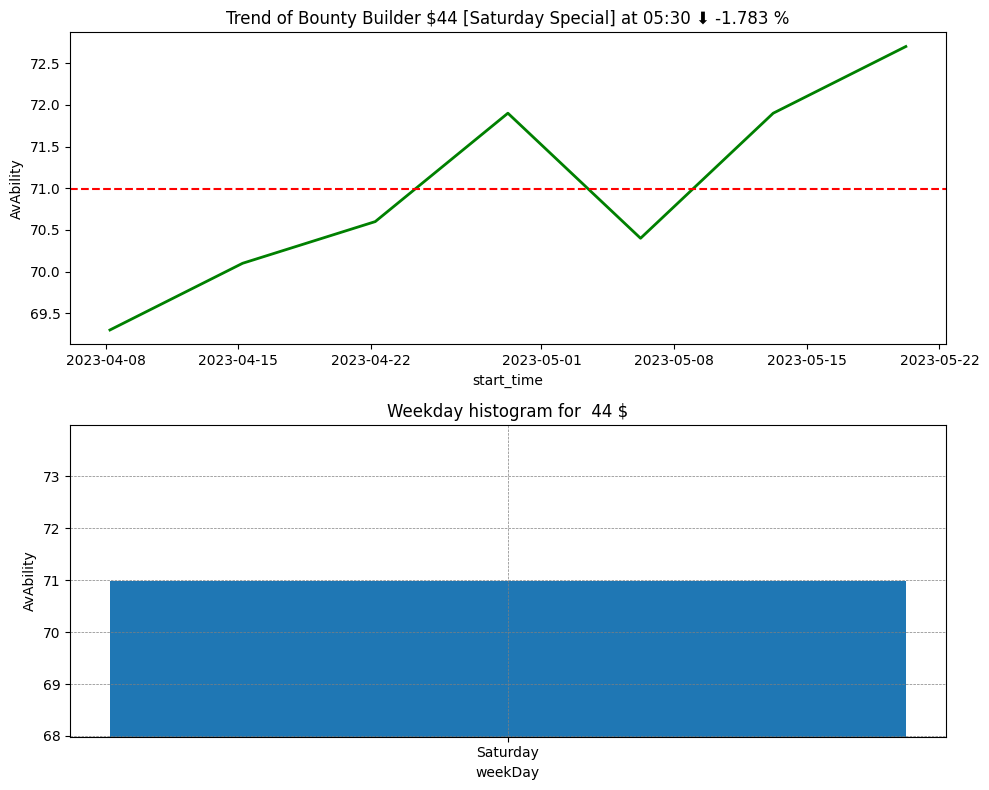

<Figure size 640x480 with 0 Axes>

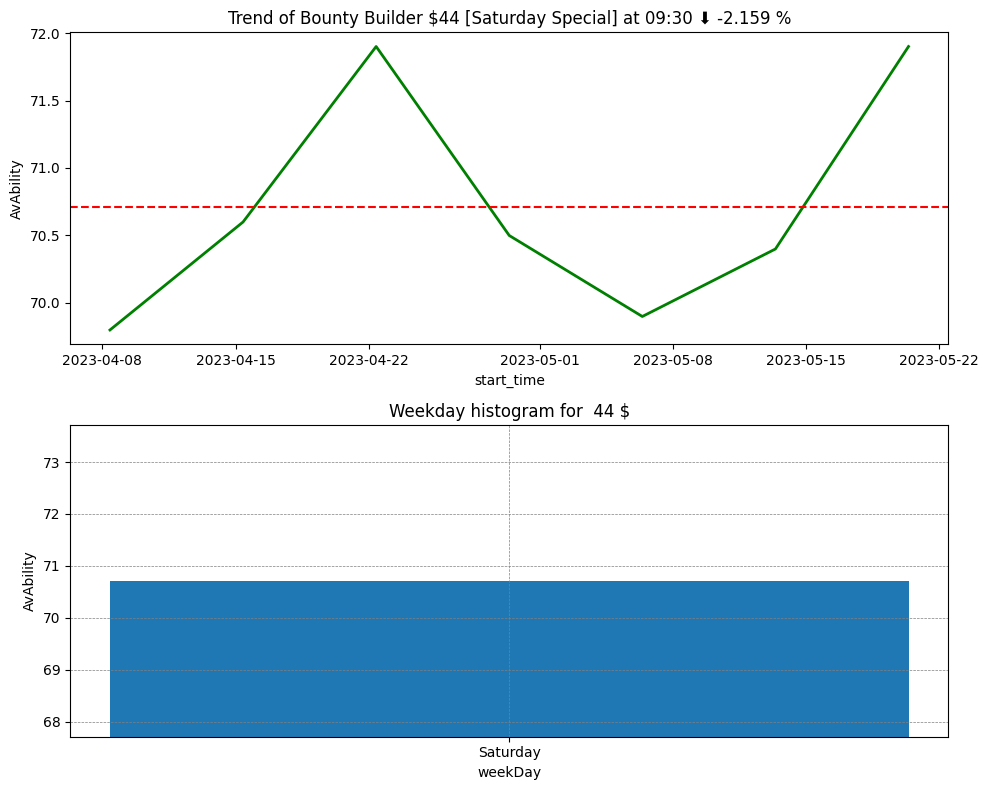

<Figure size 640x480 with 0 Axes>

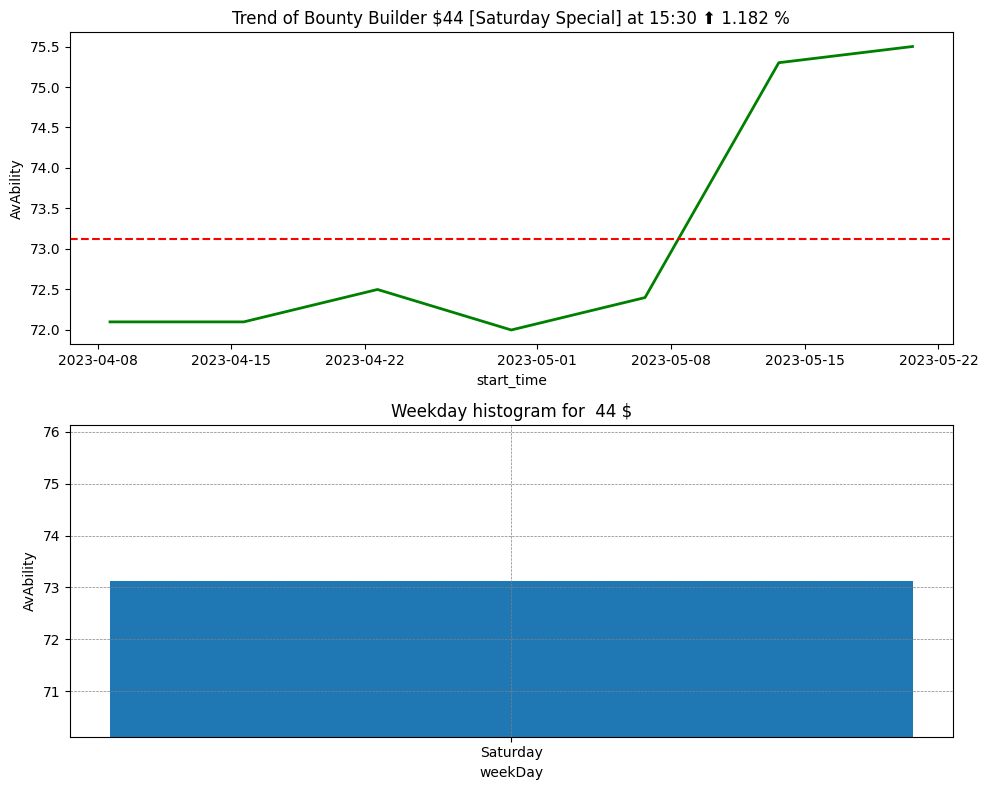

<Figure size 640x480 with 0 Axes>

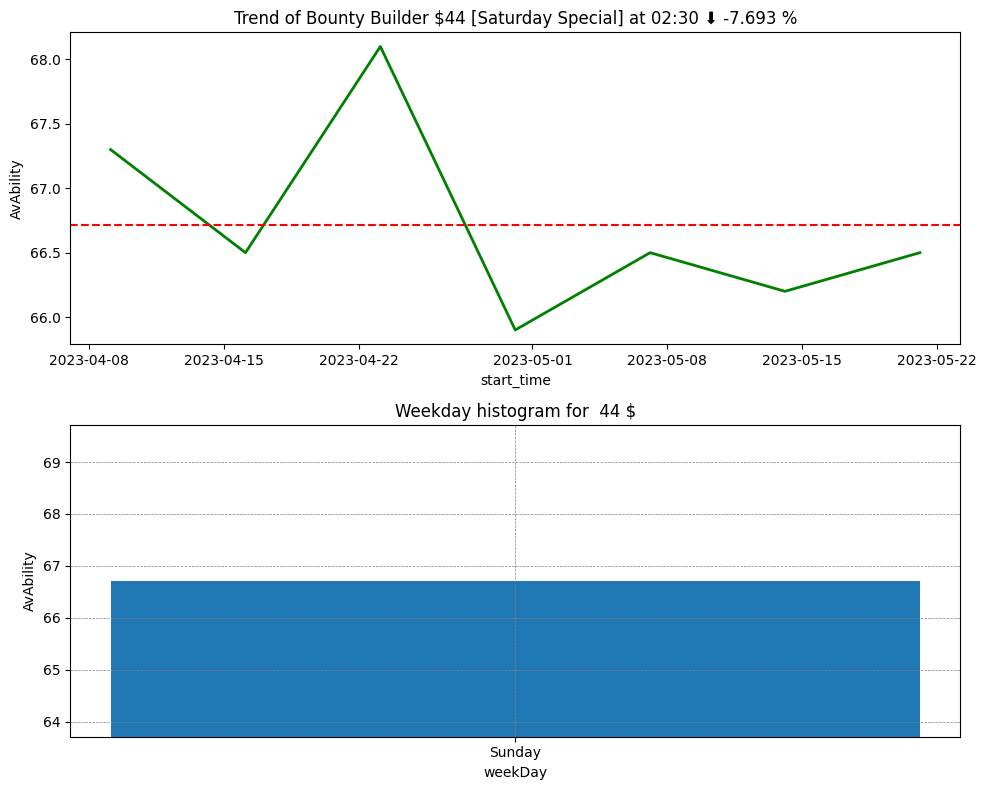

<Figure size 640x480 with 0 Axes>

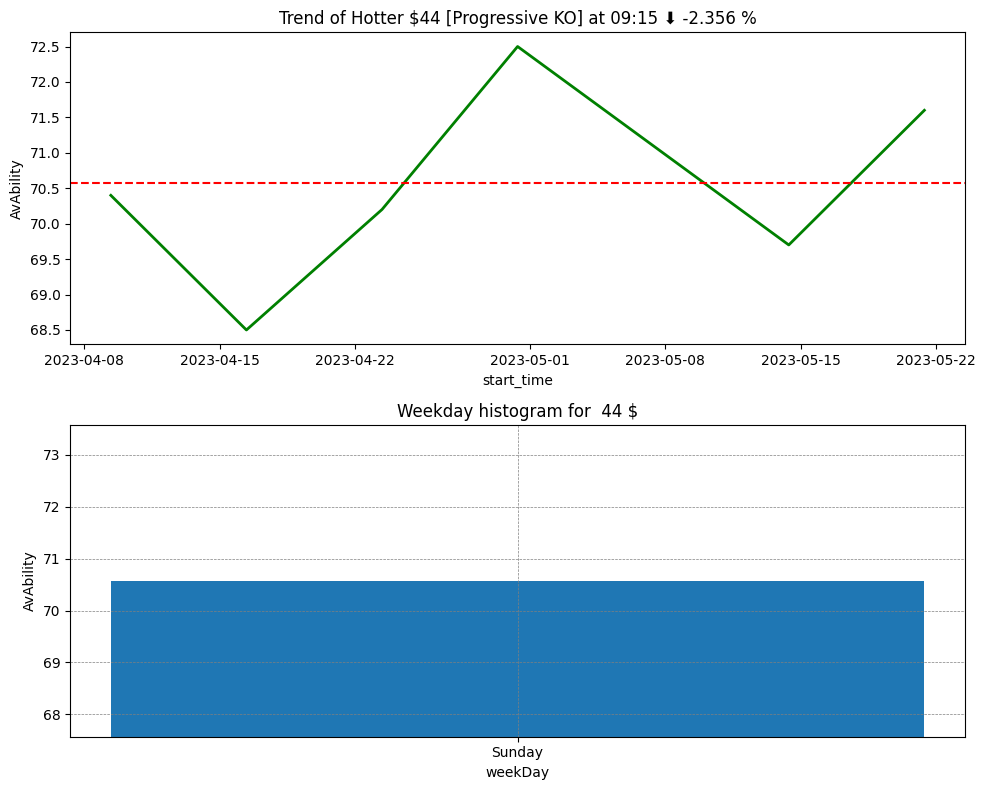

<Figure size 640x480 with 0 Axes>

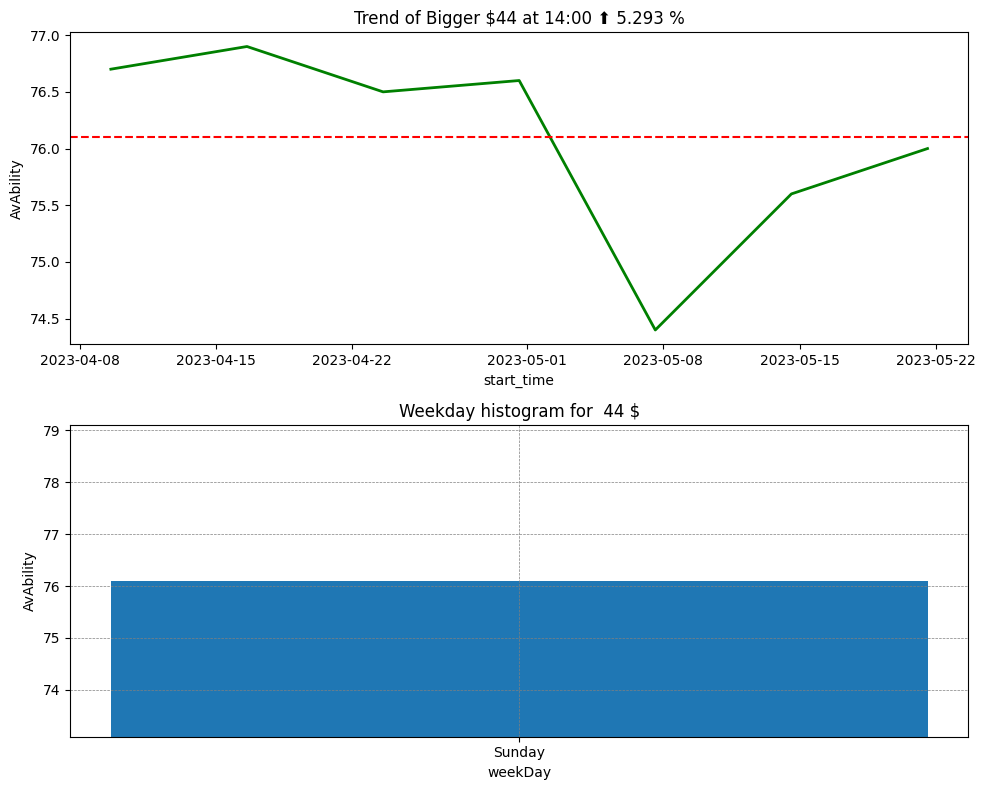

<Figure size 640x480 with 0 Axes>

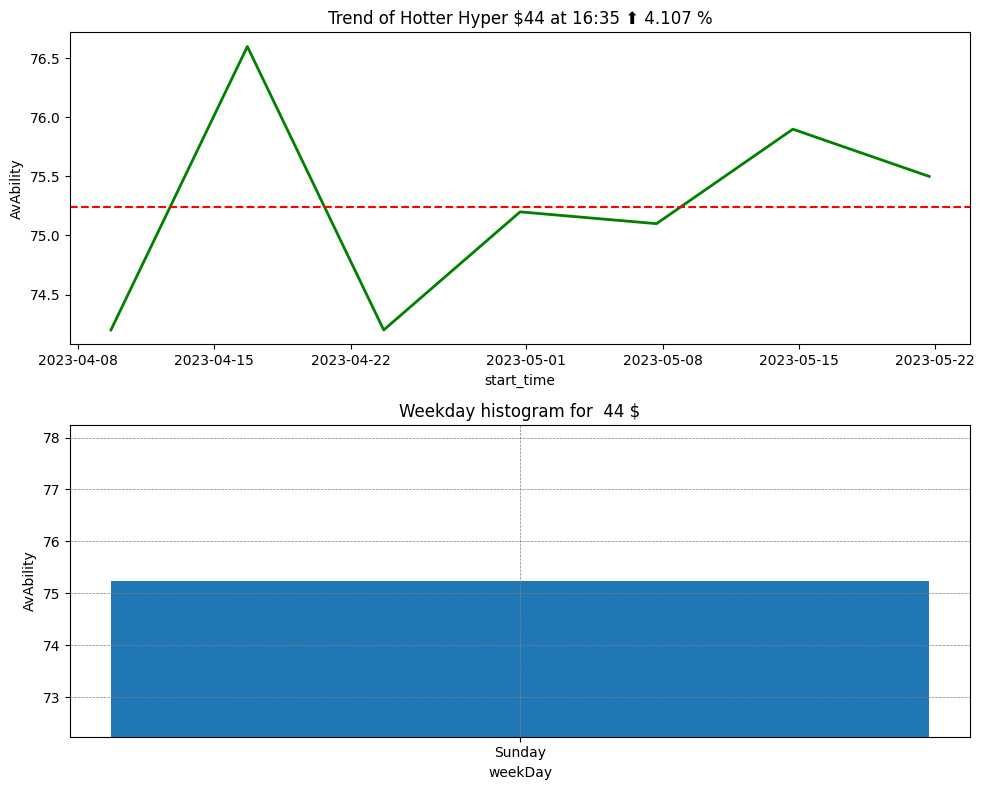

<Figure size 640x480 with 0 Axes>

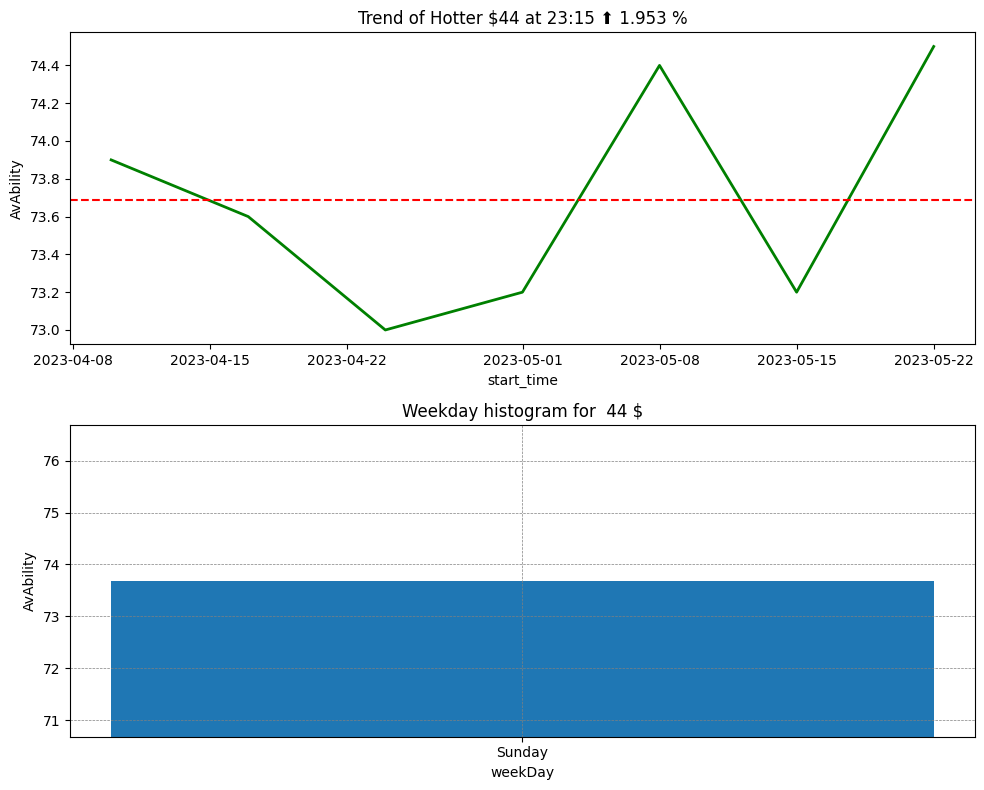

<Figure size 640x480 with 0 Axes>

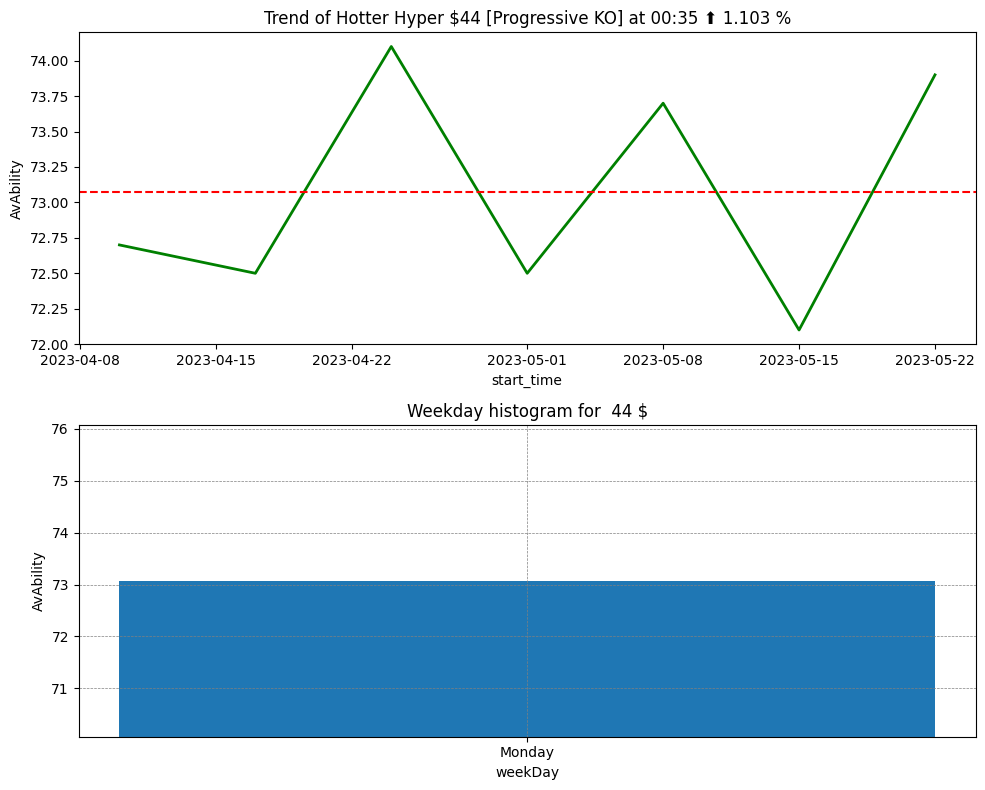

<Figure size 640x480 with 0 Axes>

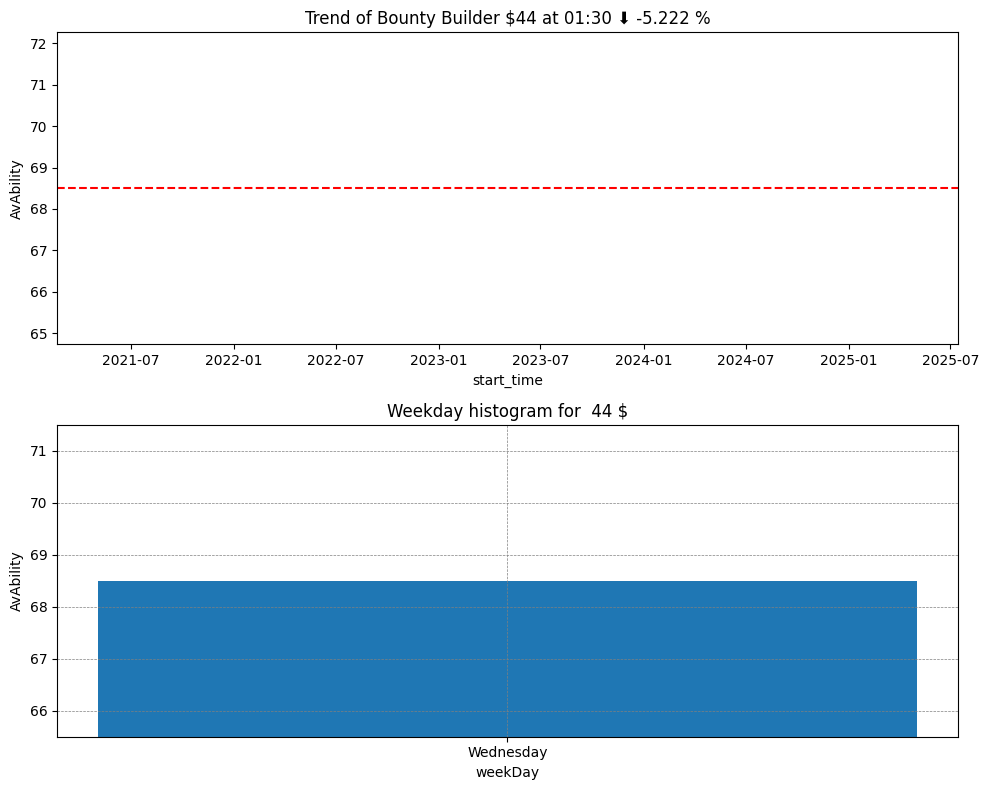

<Figure size 640x480 with 0 Axes>

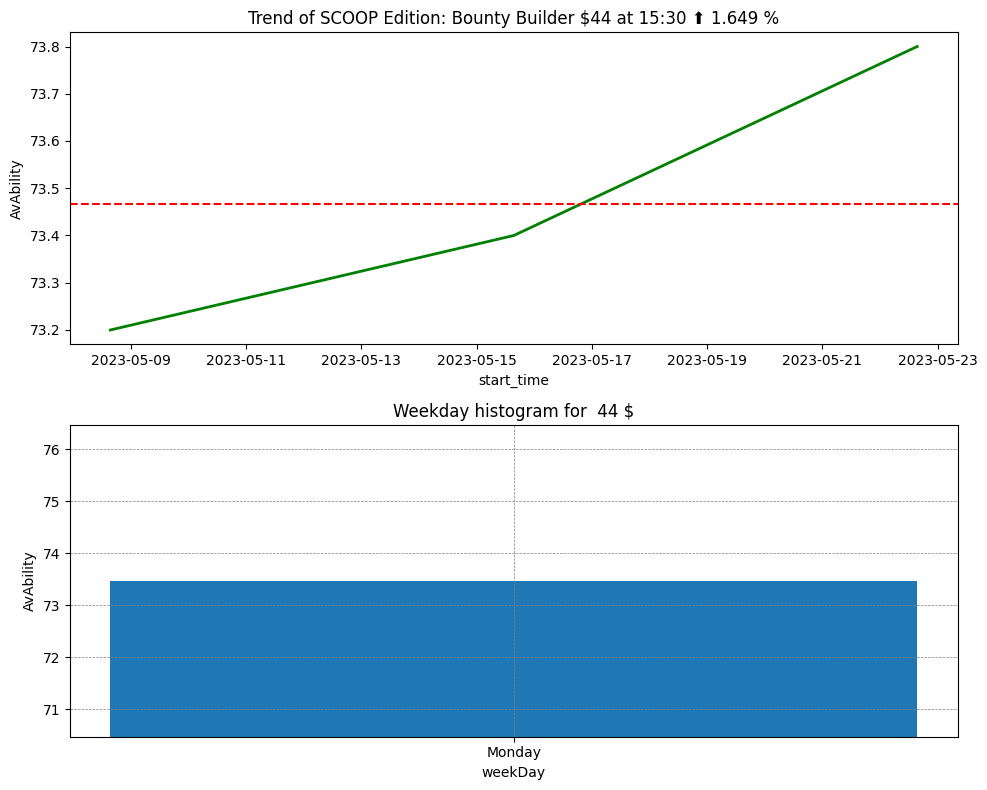

In [ ]:
buy_ins = data['buy-in'].unique()
buy_ins_names = sorted([str(int(t)) + ' $' for t in buy_ins])
bi_dropdown = widgets.Dropdown(options = buy_ins_names)

# Функция обновления графика при выборе опции в выпадающем списке

def update_plot(change):
    buy_in = int(bi_dropdown.value.split()[0])
    mask = data['buy-in'].astype(int) == buy_in
    clear_output()
    display(bi_dropdown)


    filtered_df = data[mask].sort_values('start_time')
    avg_ability = filtered_df['AvAbility'].mean()
    t_names = filtered_df['name+time'].unique()
    for tour in t_names:
    # Trend plot
      plt.clf()
      fig, ax = plt.subplots(2, 1, figsize=(10, 8))
      tour_data = filtered_df[filtered_df['name+time'] == tour]
      ax[0].plot(tour_data['start_time'], tour_data['AvAbility'], color='green', linewidth=2)
      ax[0].axhline(tour_data['AvAbility'].mean(), color='red', linestyle='--')
      pos = '\u2B06' if tour_data['AvAbility'].mean() > avg_ability else '\u2B07'
      ax[0].set_title(f'Trend of {tour} {pos} {round((tour_data["AvAbility"].mean() - avg_ability) / avg_ability * 100, 3)} %')
      ax[0].set_xlabel('start_time')
      ax[0].set_ylabel('AvAbility')

      # Weekday plot
      dd = tour_data[['weekDay', 'AvAbility']].groupby('weekDay').mean()
      ax[1].bar(dd.index, dd['AvAbility'])
      ax[1].set_title('Weekday histogram for  ' + bi_dropdown.value)
      ax[1].set_xlabel('weekDay')
      ax[1].set_ylabel('AvAbility')
      plt.ylim(dd['AvAbility'].min() - 3, dd['AvAbility'].max() + 3)
      plt.tight_layout()
      plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
      plt.show()


bi_dropdown.observe(update_plot, names='value')


display(bi_dropdown)

In [ ]:
data['buy-in'].unique()

array([  88.  ,  215.  ,   50.  ,  100.  ,  125.  ,   40.  ,   85.5 ,
         55.  ,  129.  ,   54.  ,  108.  ,   80.  ,  800.  ,  330.  ,
         60.  ,   44.  ,  150.  ,   64.5 ,   77.  ,  200.  ,  320.  ,
        388.  ,  210.  ,  140.  ,  105.  ,    5.4 ,   15.  ,   30.  ,
          3.  ,    5.  ,   20.  ,   32.1 ,    8.  ,    8.55,   25.  ,
         10.  ,   21.6 ,    6.  ,    3.21,   12.9 , 1050.  ,  250.  ,
        525.  ,   10.8 ,    8.88,    5.5 ,  840.  ,    6.45,    7.77,
          4.4 , 1200.  ,  110.  , 2023.  ,    4.  ,    8.8 ,  777.  ,
         12.  ,  888.  ,  444.  , 1175.  ,   11.  ,  500.  ,    5.4 ])